In [21]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.patches as patches

In [2]:
def load_data(csv_filepath):
    '''
    Load data from a csv file.

    :param csv_filepath: path of the .csv file containing the data to load/extract

    :return X: array of values associated with the inputs of the data contained in the .csv file
    :return Y: array of values associated with the labels of the data contained in the .csv file or None if the file does not contain labels 
    '''
    data = pd.read_csv(csv_filepath)
    # Headers' list:
    headers = data.columns # 'x' for inputs, 'y' for labels
    # Extract DataFrames based on the headers:
    x_data = data[headers[0]]
    # Convert an array-like string (e.g., '[0.02, 1.34\n, 2.12, 3.23\n]') 
    # into an array of floats (e.g., [0.02, 1.34, 2.12, 3.23]):
    X_data = [[float(feature) for feature in feature_vec.replace('[', '').replace(']', '').split()] for feature_vec in x_data]
    # convert data into numpy arrays
    X = np.array(X_data)

    if len(headers)>1:
        Y_data = data[headers[1]]
        Y = np.array(Y_data)
    else:
        Y = None
    return X, Y

X_1, y_1 = load_data("./HW1_datasets_public/dataset1.csv")
X_2, y_2 = load_data("./HW1_datasets_public/dataset2.csv")

In [136]:
# jupyter nbconvert --to html --no-input homework1.ipynb

# Table of Contents

- [Introduction](#Introduction)
- [Medium Size Dataset](#medium-size-dataset)
    - [Data Mining](#data-mining)
    - [Model Selection](#model-selection)
- [Large Size Dataset](#large-size-dataset)
    - [Data Mining again](#data-mining-again)
    - [Model Selection again](#model-selection-again)

# Introduction

Our goal is to determine the best models for two classification tasks with two different input spaces. The two datasets have the same length in terms of samples (i.e., ~50,000). The only difference is that the datasets have 100 and 1000 features, respectively. The first part is equal across the two datasets since they are very similar. We have no information about the nature of the datasets; some assumptions will be made, in particular I will assume that the datasets are mostly noise-free. Since no information about the nature of the datasets was provided, we cannot make assumptions about the hypothesis space. Thus, we have to choose the best algorithm based on performance, in the first case, and on the internal information that it carries, in the second case.

# Medium size dataset

### Data mining

The first thing that we should do is build intuition from the data. A good way to do this is to visualize the data. We have an input space of 100-dimensional features, so we need a hyperplane large enough to fit all our data. We are limited in how many dimensions we can visualize, so we need to figure out a way to do it in three dimensions or fewer and in a way that the reduction is still significant in a graphical way to gain insights. A popular way to accomplish this task is to use t-SNE; it essentially performs a non-linear transformation of an N-dimensional space into a lower-dimensional space of dimension D $\le 3$. Applying t-SNE is computationally expensive, meaning that applying it directly to the dataset is slow, with a runtime of approximately ~5 minutes per run on my machine.

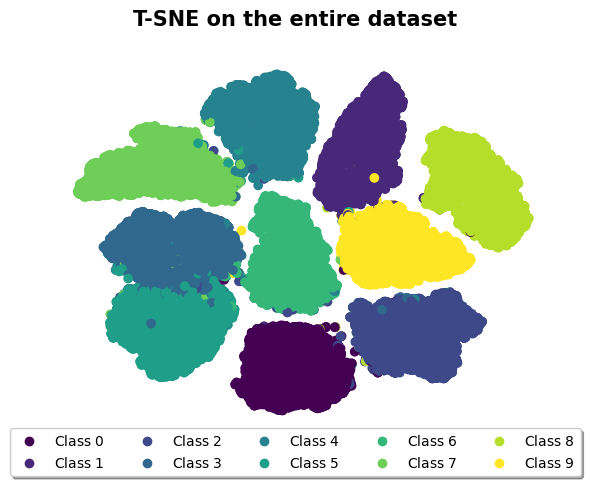

In [137]:
tsne_full = TSNE(n_components=2, learning_rate='auto',
            init='random', perplexity=30).fit_transform(X_1)
fig,ax = plt.subplots()
sct = ax.scatter(tsne_full[:,0],tsne_full[:,1],c = y_1)
fig.suptitle("T-SNE on the entire dataset", fontweight='bold',fontsize = 15)
ax.set_axis_off()
fig.legend(sct.legend_elements()[0],[f"Class {i}" for i in sct.legend_elements()[1]],loc='lower center',
          ncol=5, fancybox=True, shadow=True)
plt.show()

Even though t-SNE is widely used for accomplishing this task, a drawback is its great dependence on the 'perplexity' parameter. We would like to test if the previous graph still holds with different configurations of perplexity. However, as previously stated, if every run takes ~5 minutes to complete, we are limited in the way in which we can make fine-tuning.

As explained in the introduction, we have no information about the data, but our goal remains to get a model that best fits future unseen data, regardless of the information that we have. In this context, a reasonable assumption is that the data is generated by the same prior probability distribution. Therefore, in order to reduce the time of t-SNE, we could leverage it and scale our dataset to be smaller but without losing information about the prior probability.

Another factor that slows down t-SNE is the presence of many attributes, and not all of them may be useful in terms of the information they convey. We can determine the principal components of this dataset by using PCA. PCA determines the principal components with the insight that higher variance components carry the most information. To reduce the number of total dimensions, we can take the first 'n' components that hold a certain percentage of information. For example, in our dataset, around 9 components carry as much as 98% of the total information about the dataset. In other words, by discarding 91 dimensions, we only lose around 2% of information.

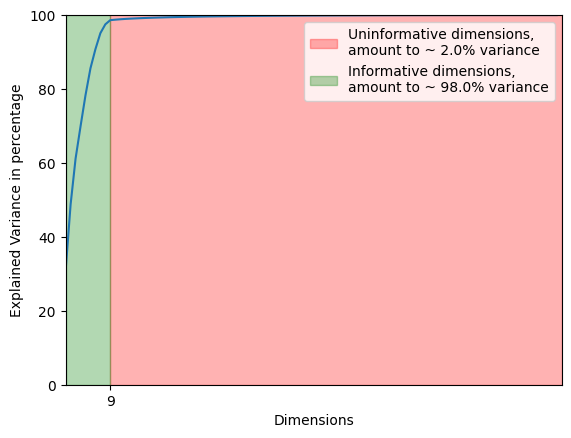

In [138]:
X_1_reduced, _, y_1_reduced, _ = train_test_split(X_1, y_1, test_size=0.9, random_state=42)
pca_1 = PCA()
pca_1.fit(X_1_reduced)
cumsum = np.cumsum(pca_1.explained_variance_ratio_)*100
perc = 96
d  = np.argmax(cumsum >= perc) +1

plt.plot(cumsum)
plt.axis([0,100,0,100])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance in percentage")

plt.fill_between(
    list(range(101)),y1 = 100, where =[i >=d for i in range(101)] ,
    color='red', alpha=0.3,
    label=f'Uninformative dimensions,\namount to ~ {np.round(sum(pca_1.explained_variance_ratio_[d:]),2) * 100}% variance'
    )
plt.fill_between(
    list(range(101)),y1 = 100,
    where =[i <= d for i in range(101)] ,
    color='green', alpha=0.3,
    label=f'Informative dimensions,\namount to ~ {np.round(sum(pca_1.explained_variance_ratio_[:d]),2) * 100}% variance')
plt.xticks(ticks= [d])
plt.legend()
plt.show()

After removing 81 dimensions and reducing the dataset to about 10% of the initial size, we can check if the first graph still holds. It seems that it is indeed the case.
But before proceeding, one thing I should point out is this: t-SNE makes a non-linear transformation. Therefore, after seeing this graph, we cannot say, for example, that class 8 and 9 are linearly separable because, after a non-linear transformation, we lose information about linearity. What we're interested in with t-SNE is the fact that it models high-dimensional objects in a way that similar objects are modeled nearby, and different objects are distant. So, we should pay attention to class 3 and 5, but let's not get ahead of ourselves.

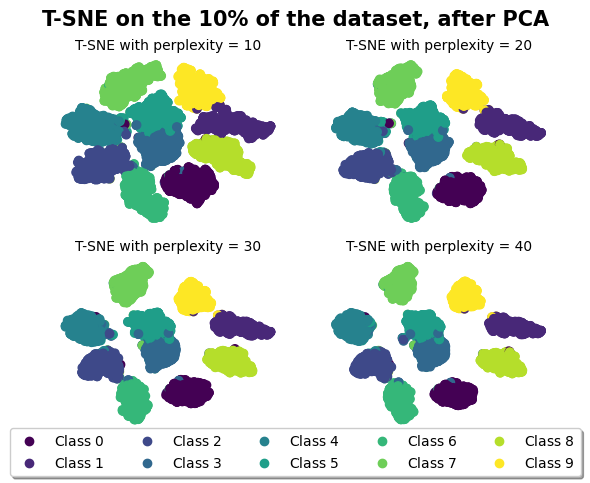

In [144]:
fig, ax = plt.subplots(2,2)
fig.suptitle(r"T-SNE on the 10% of the dataset, after PCA", fontweight='bold',fontsize = 15)
pca_1 = PCA(n_components=9)
X_1_reduced_pca = pca_1.fit_transform(X_1_reduced)
c = 1
for i in range(2):
    for j in range(2):
        tsne = TSNE(n_components=2,random_state=42, perplexity=10*c).fit_transform(X_1_reduced_pca)
        sct = ax[i][j].scatter(tsne[:,0],tsne[:,1],c = y_1_reduced)
        ax[i][j].set_title(f"T-SNE with perplexity = {10*c}",fontsize = 10)
        ax[i][j].set_axis_off()
        c+=1
fig.legend(sct.legend_elements()[0],[f"Class {i}" for i in sct.legend_elements()[1]],loc='lower center', 
          ncol=5, fancybox=True, shadow=True)
plt.show()

Lastly, before moving on, we simply note that the dataset is balanced. This too will be useful later.

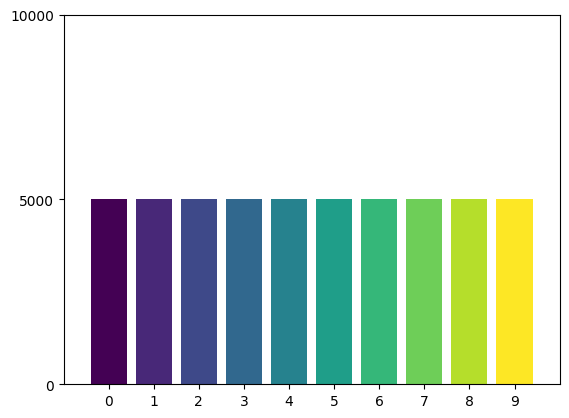

In [145]:
n_per_class = [sum(y_1 == i) for i in range(10)]
n_class = np.unique(y_1) 
plt.bar(n_class,n_per_class,color=plt.cm.viridis(np.linspace(0, 1, len(set(y_1)))))
plt.axis([-1,len(n_class),0,max(n_per_class)*2])
plt.xticks(range(0,len(set(y_1))))
plt.yticks(range(0,(max(n_per_class)*2)+1,max(n_per_class)))
plt.show()

### Model Selection

The first thing we can do is start trying different learning agorithms and choose the best based on the performance.
We can avoid doing that. 
Generally speaking multiclass classifiers can be seen as a set of binary classifiers that chooses the class of the prediction using a strategy One vs One or One vs Other, in both cases we have a set of binary classificators.
In this regard SVM is the best classifier, it differs from the other classifiers because it not only selects a generic decision boundary, but chooses which maximizes the distance from the closest data points of all classes, called maximum margin decision boundary.
By picking the decision boundary with maximum margin we reduce the generalization error, and so our model will perform better on unseen data (intuitively we have more leeway to make mistakes on both sides).
We don't know if the data is linearly separable or not, but by using the kernel trick we could choose a kernel such that the algorithm will still choose a valid decision boundary.
But nothing is free and resorting to the kernel trick means that we're locked in the dual problem, thus we have to deal with a time complexity of $O(n^3)$, where $n$ is the number of samples.
This dataset is still small enough, and after the PCA we were able to reduce the number of attributes from 100 to 9, so using SVM is still manageable.
Since the dataset is balanced and we have no information about the objective that we're trying to maximize the accuracy gives us a great measure of the quality of the model.
We can use K-fold cross-validation, in this way we can evaluate the model multiple times and decide do use the model that performs better on average.

In [3]:
X_1_train, X_1_test, y_1_train, y_1_test = train_test_split(X_1, y_1, test_size=0.33, random_state=42)

In [63]:
models = {
    "Linear SVM":make_pipeline(StandardScaler(),PCA(n_components=9),SVC(kernel="linear")),
    "Radial Basis Function SVM": make_pipeline(StandardScaler(),PCA(n_components=9),SVC(kernel="rbf")),
}
scores = {}
for modelname,model in models.items():
   scores.update({modelname:np.round(cross_val_score(model,X_1_train,y_1_train,cv =10),3)})
df = pd.DataFrame(scores)

df = df.describe().iloc[[0,1,2]]
df.index = ["Cross-validation splitting strategy","Accuracy mean","Accuracy standard deviation"]
df

,Linear SVM,Radial Basis Function SVM
Cross-validation splitting strategy,10.000000,10.000000
Accuracy mean,0.987400,0.988100
Accuracy standard deviation,0.002757,0.002558


The SVM with a Radial Basis Function is the winner, as it outperforms (even if only slightly) SVM with a linear kernel. 
Even if the standard deviation is not too high (all iterations yielded an accuracy scorre really close to the mean), the mean accuracy seems to be too high, indicating a potential issue of overfitting the data, implying low generalization power. Fortunately, during the K-fold validation, we kept a portion of the dataset for testing. Using this test set, we obtain an accuracy of ~98.7%, which aligns with the data collected during the K-fold phase.

In [104]:
model = make_pipeline(StandardScaler(),PCA(n_components=9),SVC(kernel="rbf",probability=True))
model.fit(X_1_train,y_1_train)
y_1_pred = model.predict(X_1_test)
# print(accuracy_score(y_1_pred,y_1_test))

This means that, rather than overfitting, we're predicting the real function $f$ that generated the data very well. Due to several reasons such as the unknown nature of $f$, lack of information about the hypothesis space, the potential presence of noise in the data, and the finite size of the dataset, reaching $100%$ accuracy is not feasible anytime soon. While this is normal, it also implies that somewhere we're making mistakes. These mistakes take the form of misclassifications, and in order to visualize where we're making mistakes, it comes in handy to use something called a confusion matrix.

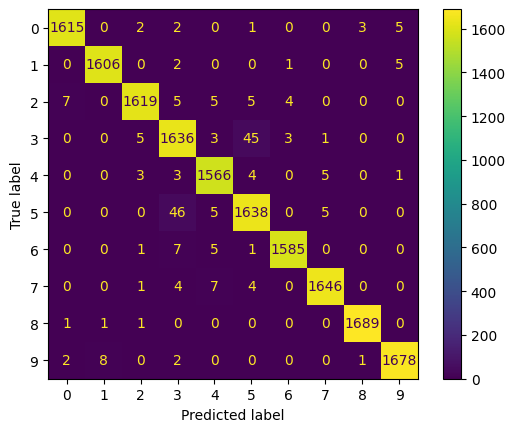

In [154]:
cm = confusion_matrix(y_1_test,y_1_pred)
ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_).plot()
plt.show()

Based on the confusion matrix, we observe that we tend to misclassify mostly classes 3 and 5, as previously noted. Let's revisit the t-SNE plot with perplexity 30 and focus only on those two classes.

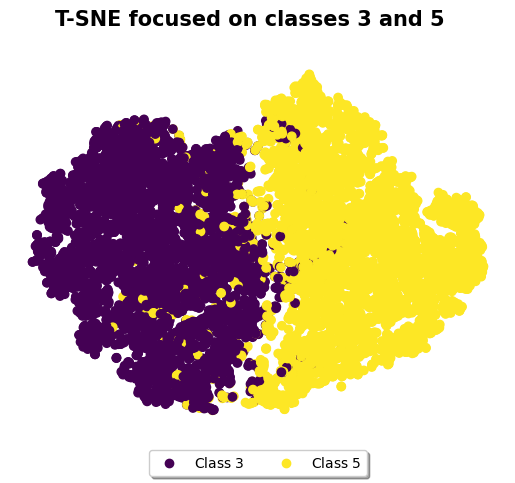

In [17]:
idx = np.logical_or(np.array(y_1) == 3,np.array(y_1) == 5)

X_1_35= model['pca'].fit_transform(model['standardscaler'].fit_transform(X_1[idx]))
y_1_35 = y_1[idx]

X_1_tsne_35 = TSNE(n_components=2, learning_rate='auto',
            init='random', perplexity=30).fit_transform(X_1_35)
fig,ax = plt.subplots()
sct = ax.scatter(X_1_tsne_35[:,0],X_1_tsne_35[:,1],c = y_1_35)
fig.suptitle("T-SNE focused on classes 3 and 5", fontweight='bold',fontsize = 15)
ax.set_axis_off()
fig.legend(sct.legend_elements()[0],[f"Class {i}" for i in sct.legend_elements()[1]],loc='lower center',
          ncol=5, fancybox=True, shadow=True)
plt.show()

In the t-SNE graph of those two classes, we observe that they seem to almost merge. We didn't explore this idea before, but let's do it now. In t-SNE, clusters contain elements that are closer in the original space while trying to keep well-separated from relatively distant points. In this case, the classes merge, meaning that in the original space, these elements were really close to each other.

We can take a step further in this analysis and note that this notion of distance can be seen as a measure of similarities. Thus, some elements of class 3 and 5 are very similar, and as a result, we have some errors classifying them.

# Large size dataset

### Data Mining again

As discussed in the introduction the datasets are very similar, so the datamining phase is mostly the same with some numbers changed.

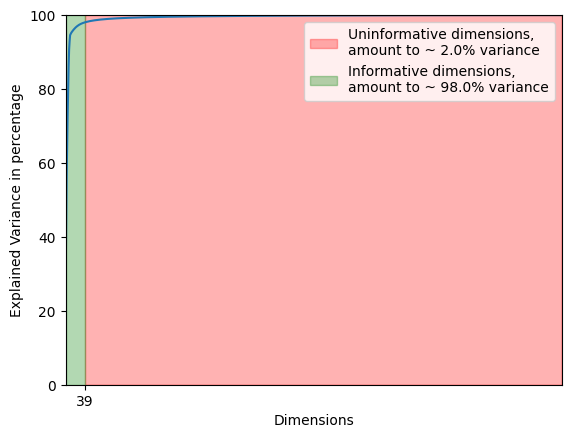

In [18]:
X_2_reduced, _, y_2_reduced, _ = train_test_split(X_2, y_2, test_size=0.9, random_state=42)


pca_2 = PCA()
pca_2.fit(X_2_reduced)
cumsum = np.cumsum(pca_2.explained_variance_ratio_)*100
perc = 98
d  = np.argmax(cumsum >= perc) +1

plt.plot(cumsum)
#plt.plot(d,0,"ko") 
plt.axis([0,1000,0,100])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance in percentage")

# # Highlight the right part in orange
plt.fill_between(list(range(1001)),y1 = 100, where =[i >=d for i in range(1001)] , color='red', alpha=0.3, label=f'Uninformative dimensions,\namount to ~ {np.round(sum(pca_2.explained_variance_ratio_[d:]),2) * 100}% variance')
plt.fill_between(list(range(1001)),y1 = 100,where =[i <= d for i in range(1001)] , color='green', alpha=0.3, label=f'Informative dimensions,\namount to ~ {np.round(sum(pca_2.explained_variance_ratio_[:d]),2) * 100}% variance')
plt.xticks(ticks= [d])

plt.legend()
plt.show()

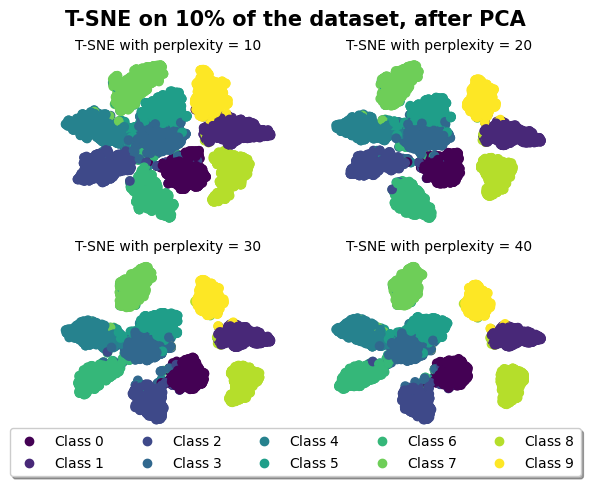

In [19]:
fig, ax = plt.subplots(2,2)
fig.suptitle(r"T-SNE on 10% of the dataset, after PCA", fontweight='bold',fontsize = 15)
pca_2 = PCA(n_components=39)
X_2_reduced_pca = pca_2.fit_transform(X_2_reduced)
c = 1
for i in range(2):
    for j in range(2):
        tsne = TSNE(n_components=2,random_state=42, perplexity=10*c).fit_transform(X_2_reduced_pca)
        sct = ax[i][j].scatter(tsne[:,0],tsne[:,1],c = y_2_reduced)
        ax[i][j].set_title(f"T-SNE with perplexity = {10*c}",fontsize = 10)
        ax[i][j].set_axis_off()
        c+=1
fig.legend(sct.legend_elements()[0],[f"Class {i}" for i in sct.legend_elements()[1]],loc='lower center', 
          ncol=5, fancybox=True, shadow=True)
plt.show()

Given what we've discussed in the medium dataset we can already say that we will have some troubles differentiating class 3,4,5,6 as the y seem to have created a cluster, but we will come to it later.

Lastly befome moving to model selection we check if the data is balanced.

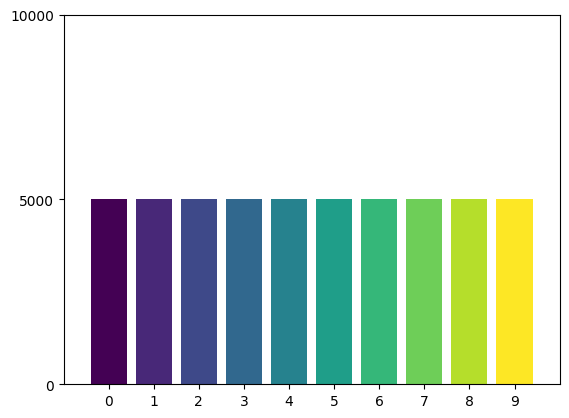

In [20]:
n_per_class = [sum(y_2 == i) for i in range(10)]
n_class = np.unique(y_2) 
plt.bar(n_class,n_per_class,color=plt.cm.viridis(np.linspace(0, 1, len(set(y_2)))))
plt.axis([-1,len(n_class),0,max(n_per_class)*2])
plt.xticks(range(0,len(set(y_2))))
plt.yticks(range(0,(max(n_per_class)*2)+1,max(n_per_class)))
plt.show()


### Model selection again

What was previously discussed about SVM still holds, but the classification task is easy enough, and we can consider choosing another model. In particular, we'll keep an eye on random forests.

Random forests are an ensemble learning method that operates by constructing a multitude of decision trees during training and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees. They offer the advantage of being less prone to overfitting and providing a good balance between bias and variance.

Given the characteristics of our dataset, including its reduced size after PCA and the balanced nature of the classes, random forests might offer a more computationally efficient alternative with the potential to capture complex relationships within the data, and direct informations about the decision process (more on this later).

As before, we can use K-fold cross-validation to evaluate the performance of the random forest model and select the configuration that performs the best on average across the folds. This will help us make an informed decision about which model to choose for our classification task.

In [22]:
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2, y_2, test_size=0.33, random_state=42)

In [67]:
models = {
    "Random Forest" : make_pipeline(PCA(n_components=39),RandomForestClassifier()),
    "Radial Basis Function SVM": make_pipeline(StandardScaler(),PCA(n_components=39),SVC(kernel="rbf"))
}
scores = {}
for modelname,model in models.items():
   scores.update({modelname:np.round(cross_val_score(model,X_2_train,y_2_train,cv =10),3)})
df = pd.DataFrame(scores)

df = df.describe().iloc[[0,1,2]]
df.index = ["Cross-validation splitting strategy","Accuracy mean","Accuracy standard deviation"]
df

,Random Forest,Radial Basis Function SVM
Cross-validation splitting strategy,10.000000,10.000000
Accuracy mean,0.972500,0.973900
Accuracy standard deviation,0.003308,0.003315


Technically speaking, SVM is slightly better than random forests, but we still reach a 96.9% accuracy, so we're not losing much. However, we gain the fact that random forest makes decisions about the classification result by using the classification that has the highest probability of being true.

If we visualize the confusion matrix...

In [68]:

model = make_pipeline(PCA(n_components=39),RandomForestClassifier())
model.fit(X_2_train,y_2_train)
y_2_pred = model.predict(X_2_test)
# print(accuracy_score(y_2_pred,y_2_test))

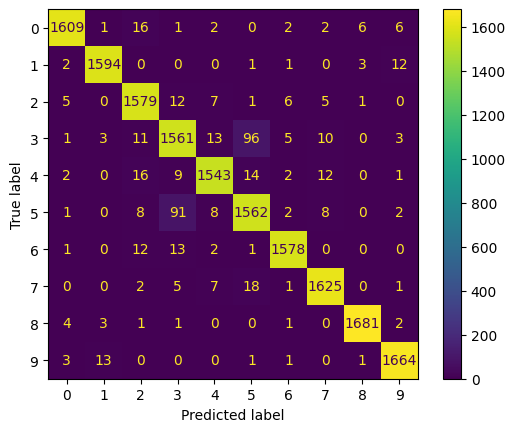

In [25]:
cm = confusion_matrix(y_2_pred,y_2_test)
ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_).plot()
plt.show()

From the confusion matrix, we gather that, as before, there is a bit of confusion between 3 and 5, and they tend to be swapped. But if we take a good look at the matrix, it doesn't really describe what we expect.

By looking at the t-SNE graph, we expected higher misclassifications among classes 3, 4, 5, and 6. So, let's take another look at the t-SNE graph and just focus on those classes.

We'll also take two particular points that will highlight why this peculiarity happens.

In [31]:
X_2_test_3456 = X_2_test[np.logical_or(np.logical_or(np.logical_or(y_2_test==3,y_2_test==4),y_2_test==5),y_2_test==6)]
y_2_test_3456 = y_2_test[np.logical_or(np.logical_or(np.logical_or(y_2_test==3,y_2_test==4),y_2_test==5),y_2_test==6)]

In [29]:
tsne_2_3456 = TSNE(random_state=42)
pca_2_3456  = PCA(n_components=39)
X_2_tsne_3456 = tsne_2_3456.fit_transform(pca_2_3456 .fit_transform(X_2_test_3456))

In [100]:
# Find the blue circle = 6519
red =[]
blue =[]
cp = [(prob_prediction[[3,4,5,6]] >= 20).astype(np.uint8) for prob_prediction in model.predict_proba(X_2_test_3456)*100]
p = [prediction for prediction in model.predict(X_2_test_3456)]

for i in range(len(X_2_test_3456)):
    # Check that a point has " high indecision", where high indecision means that have 3 or more probabilities higher than 20
    if cp[i].sum() >=3 and y_2_test_3456[i] != p[i]:
        red.append(i)
    if cp[i].sum() >=3 and y_2_test_3456[i] == p[i]:
        blue.append(i)


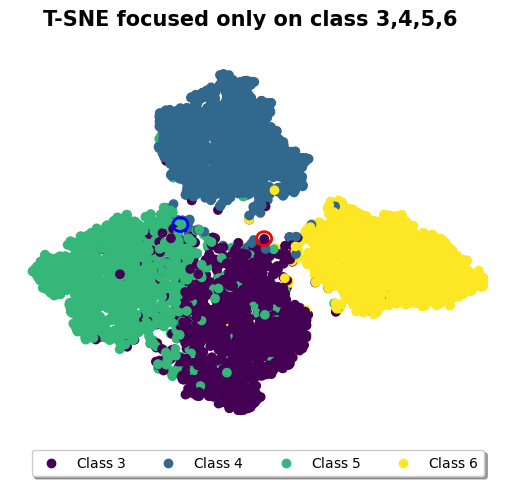

In [102]:
fig,ax = plt.subplots()
sct = ax.scatter(X_2_tsne_3456[:,0],X_2_tsne_3456[:,1],c =y_2_test_3456)
fig.suptitle("T-SNE focused only on class 3,4,5,6", fontweight='bold',fontsize = 15)
ax.set_axis_off()
fig.legend(sct.legend_elements()[0],[f"Class {i}" for i in sct.legend_elements()[1]],loc='lower center',# bbox_to_anchor=(0.5, 1.05),
          ncol=5, fancybox=True, shadow=True)

[ax.add_patch(patches.Circle(X_2_tsne_3456[i,:], 3, edgecolor='red', facecolor='none', linewidth=2, label='Circle')) for i in [red[0]]]
[ax.add_patch(patches.Circle(X_2_tsne_3456[i,:], 3, edgecolor='blue', facecolor='none', linewidth=2, label='Circle')) for i in [blue[0]]]
plt.show()

What's interesting about these two points is that the blue one has been correctly classified, while the red one has not. However, since we're using decision trees, we can query the probability of being part of a given class. Technically, this can also be done with SVM, but decision trees are more suited for this kind of thing. This results in a ten-dimensional array (there are ten possible classes) in which every element gives us the information of being classified as being of the class equal to the index.

In [103]:
data ={
    "Probabilities of Red Circle": np.append(
        (model.predict_proba(X_2_test_3456[red[0]].reshape(1,-1))*100)[0],
        [y_2_test_3456[red[0]],
        model.predict(X_2_test_3456[red[0]].reshape(1,-1))[0]]
        )
    ,
    "Probabilities of Blue Circle": np.append(
        (model.predict_proba(X_2_test_3456[blue[0]].reshape(1,-1))*100)[0],
        [y_2_test_3456[blue[0]],
        model.predict(X_2_test_3456[blue[0]].reshape(1,-1))[0]]
        ),
}
df = pd.DataFrame.from_dict(data)
df.index = [f"Probability of being of class {i}" for i in range(10)] + ["Real value", "Prediction"]
df


,Probabilities of Red Circle,Probabilities of Blue Circle
Probability of being of class 0,1.0,0.0
Probability of being of class 1,1.0,0.0
Probability of being of class 2,1.0,0.0
Probability of being of class 3,32.0,20.0
Probability of being of class 4,22.0,32.0
Probability of being of class 5,29.0,48.0
Probability of being of class 6,1.0,0.0
Probability of being of class 7,3.0,0.0
Probability of being of class 8,3.0,0.0
Probability of being of class 9,7.0,0.0


What is remarkable is that these two particular points have high uncertainty around being classified as class 3, 4, or 5, which is in line with what we saw in the t-SNE graph. Another interesting aspect is the fact that if the subset on which we had done the training would change, these points might get interchanged (the red one being correctly classified while the blue one is not). This sensitivity to the training subset highlights the complex relationships and potential overlaps between classes in our dataset.

# Resources

[Is normalization always good ?](https://stats.stackexchange.com/questions/189652/is-it-a-good-practice-to-always-scale-normalize-data-for-machine-learning)

[How to visualize features in case of classification problem?](https://stats.stackexchange.com/questions/261810/how-to-visualize-features-in-case-of-classification-problem)

[How to yse t-SNE effectively](https://distill.pub/2016/misread-tsne/)

[Why is PCA often used before t-SNE](https://datascience.stackexchange.com/questions/56758/why-is-pca-often-used-before-t-sne-for-problems-when-the-goal-is-only-to-reduce)

[t-SNE clearly explained](https://towardsdatascience.com/t-sne-clearly-explained-d84c537f53a)

[SVM why look for maxim margin](https://medium.com/geekculture/svm-why-look-for-maximum-margin-9f650eb29ce1)

[Scikit documentation about t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)

[What is Principal Component Analysis and how it is used](https://www.sartorius.com/en/knowledge/science-snippets/what-is-principal-component-analysis-pca-and-how-it-is-used-507186#:~:text=Principal%20component%20analysis%2C%20or%20PCA,more%20easily%20visualized%20and%20analyzed.)

[Hands on Machine Learning with Scikit-Learn, Keras and TensorFlow, 2nd Edition](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/)
[Hands on Machine Learning with Scikit-Learn, Keras and TensorFlow, 2nd Edition - github repo](https://github.com/ageron/handson-ml2)
[Bishop Pattern Recognition and Machine Learning](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf)
[Machine Learning, Tom Mitchell](http://www.cs.cmu.edu/~tom/mlbook.html)